# Greg

# James

# Han

# Rachel

# Himasri

#### Analysis 
1. ROI per genre 
2. Popularity per genre
3. Avg worldwide gross per genre
4. Buget -> worldwide gross
5. Best runtime for movie 
6. Best month to release the mvoie

#### Variables to explore
1. Revenue = worldwide gross
2. Profit = Revenue - Budget

In [1]:
import pandas as pd

In [2]:
tmdb_df = pd.read_csv("zippedData/tmdb.movies.csv.gz", index_col = 0)
tmdb_df.head()

,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


In [3]:
tn_df = pd.read_csv("zippedData/tn.movie_budgets.csv.gz", index_col = 0)
tn_df

,release_date,movie,production_budget,domestic_gross,worldwide_gross
id,,,,,
1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"
...,...,...,...,...,...
78,"Dec 31, 2018",Red 11,"$7,000",$0,$0
79,"Apr 2, 1999",Following,"$6,000","$48,482","$240,495"
80,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338","$1,338"


In [4]:
rtmovies_df = pd.read_csv("zippedData/rt.movie_info.tsv.gz", sep='\t')
rtmovies_df

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1555,1996,Forget terrorists or hijackers -- there's a ha...,R,Action and Adventure|Horror|Mystery and Suspense,NaN,NaN,"Aug 18, 2006","Jan 2, 2007",$,"33,886,034",106 minutes,New Line Cinema
1556,1997,The popular Saturday Night Live sketch was exp...,PG,Comedy|Science Fiction and Fantasy,Steve Barron,Terry Turner|Tom Davis|Dan Aykroyd|Bonnie Turner,"Jul 23, 1993","Apr 17, 2001",NaN,NaN,88 minutes,Paramount Vantage
1557,1998,"Based on a novel by Richard Powell, when the l...",G,Classics|Comedy|Drama|Musical and Performing Arts,Gordon Douglas,NaN,"Jan 1, 1962","May 11, 2004",NaN,NaN,111 minutes,NaN
1558,1999,The Sandlot is a coming-of-age story about a g...,PG,Comedy|Drama|Kids and Family|Sports and Fitness,David Mickey Evans,David Mickey Evans|Robert Gunter,"Apr 1, 1993","Jan 29, 2002",NaN,NaN,101 minutes,NaN


In [5]:
rtreviews_df = pd.read_csv("zippedData/rt.reviews.tsv.gz", sep='\t', encoding= 'unicode_escape' )
rtreviews_df

,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018"
3,3,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017"
4,3,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017"
...,...,...,...,...,...,...,...,...
54427,2000,The real charm of this trifle is the deadpan c...,NaN,fresh,Laura Sinagra,1,Village Voice,"September 24, 2002"
54428,2000,NaN,1/5,rotten,Michael Szymanski,0,Zap2it.com,"September 21, 2005"
54429,2000,NaN,2/5,rotten,Emanuel Levy,0,EmanuelLevy.Com,"July 17, 2005"
54430,2000,NaN,2.5/5,rotten,Christopher Null,0,Filmcritic.com,"September 7, 2003"


In [6]:
import sqlite3
import pandas as pd
import regex as re
from zipfile import ZipFile

In [7]:
#conn = sqlite3.connect('zippedData/im.db')

In [8]:
file_name = "./zippedData/im.db.zip"
# opening the zip file in READ mode
with ZipFile(file_name, 'r') as zip:
    # printing all the contents of the zip file
    #zip.printdir()
    zip.extractall()
    

In [9]:
conn = sqlite3.connect('./im.db')
#cur = conn.cursor()

In [10]:
# Table names
pd.read_sql('''
SELECT 
    name
FROM 
    sqlite_schema
WHERE 
    type ='table' AND 
    name NOT LIKE 'sqlite_%';
''',conn)

,name
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


In [11]:
q = """ SELECT * FROM movie_basics """
movie_basics_df = pd.read_sql(q,conn)

In [12]:
movie_basics_df

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"
...,...,...,...,...,...,...
146139,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.0,Drama
146140,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,NaN,Documentary
146141,tt9916706,Dankyavar Danka,Dankyavar Danka,2013,NaN,Comedy
146142,tt9916730,6 Gunn,6 Gunn,2017,116.0,None


In [13]:
q = """ SELECT * FROM directors """
directors_df = pd.read_sql(q,conn)

In [14]:
directors_df

,movie_id,person_id
0,tt0285252,nm0899854
1,tt0462036,nm1940585
2,tt0835418,nm0151540
3,tt0835418,nm0151540
4,tt0878654,nm0089502
...,...,...
291169,tt8999974,nm10122357
291170,tt9001390,nm6711477
291171,tt9001494,nm10123242
291172,tt9001494,nm10123248


In [15]:
q = """ SELECT * FROM known_for """
known_for_df = pd.read_sql(q,conn)
known_for_df

,person_id,movie_id
0,nm0061671,tt0837562
1,nm0061671,tt2398241
2,nm0061671,tt0844471
3,nm0061671,tt0118553
4,nm0061865,tt0896534
...,...,...
1638255,nm9990690,tt9090932
1638256,nm9990690,tt8737130
1638257,nm9991320,tt8734436
1638258,nm9991320,tt9615610


In [16]:
q = """ SELECT * FROM persons """
persons_df = pd.read_sql(q,conn)
persons_df

,person_id,primary_name,birth_year,death_year,primary_profession
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer"
1,nm0061865,Joseph Bauer,NaN,NaN,"composer,music_department,sound_department"
2,nm0062070,Bruce Baum,NaN,NaN,"miscellaneous,actor,writer"
3,nm0062195,Axel Baumann,NaN,NaN,"camera_department,cinematographer,art_department"
4,nm0062798,Pete Baxter,NaN,NaN,"production_designer,art_department,set_decorator"
...,...,...,...,...,...
606643,nm9990381,Susan Grobes,NaN,NaN,actress
606644,nm9990690,Joo Yeon So,NaN,NaN,actress
606645,nm9991320,Madeline Smith,NaN,NaN,actress
606646,nm9991786,Michelle Modigliani,NaN,NaN,producer


In [17]:
q = """ SELECT * FROM principals """
principals_df = pd.read_sql(q,conn)
principals_df

,movie_id,ordering,person_id,category,job,characters
0,tt0111414,1,nm0246005,actor,None,"[""The Man""]"
1,tt0111414,2,nm0398271,director,None,None
2,tt0111414,3,nm3739909,producer,producer,None
3,tt0323808,10,nm0059247,editor,None,None
4,tt0323808,1,nm3579312,actress,None,"[""Beth Boothby""]"
...,...,...,...,...,...,...
1028181,tt9692684,1,nm0186469,actor,None,"[""Ebenezer Scrooge""]"
1028182,tt9692684,2,nm4929530,self,None,"[""Herself"",""Regan""]"
1028183,tt9692684,3,nm10441594,director,None,None
1028184,tt9692684,4,nm6009913,writer,writer,None


In [18]:
q = """ SELECT * FROM writers """
writers_df = pd.read_sql(q,conn)
writers_df

,movie_id,person_id
0,tt0285252,nm0899854
1,tt0438973,nm0175726
2,tt0438973,nm1802864
3,tt0462036,nm1940585
4,tt0835418,nm0310087
...,...,...
255868,tt8999892,nm10122246
255869,tt8999974,nm10122357
255870,tt9001390,nm6711477
255871,tt9004986,nm4993825


In [19]:
q = """ SELECT * FROM movie_ratings """
movie_ratings_df = pd.read_sql(q,conn)

In [20]:
movie_ratings_df 

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21
...,...,...,...
73851,tt9805820,8.1,25
73852,tt9844256,7.5,24
73853,tt9851050,4.7,14
73854,tt9886934,7.0,5


In [21]:
q = """ SELECT * FROM movie_akas """
movie_akas_df = pd.read_sql(q,conn)

In [22]:
movie_akas_df.head()

,movie_id,ordering,title,region,language,types,attributes,is_original_title
0,tt0369610,10,Джурасик свят,BG,bg,None,None,0.0
1,tt0369610,11,Jurashikku warudo,JP,None,imdbDisplay,None,0.0
2,tt0369610,12,Jurassic World: O Mundo dos Dinossauros,BR,None,imdbDisplay,None,0.0
3,tt0369610,13,O Mundo dos Dinossauros,BR,None,None,short title,0.0
4,tt0369610,14,Jurassic World,FR,None,imdbDisplay,None,0.0


In [23]:
# Join movie_basics and movie ratings tables
joined_df = movie_ratings_df.merge(movie_basics_df, how="inner", on="movie_id")

In [24]:
#Shape of the dataset
joined_df.shape

(73856, 8)

In [25]:
# Check for Duplicate values
joined_df.duplicated().sum()

0

In [26]:
#Check for null values
joined_df.isnull().sum()

movie_id              0
averagerating         0
numvotes              0
primary_title         0
original_title        0
start_year            0
runtime_minutes    7620
genres              804
dtype: int64

##### There are missing values in runtime_minutes and genres column

In [27]:
# Drop rows with null values 
joined_df.dropna(subset = ["runtime_minutes", "genres"], inplace=True)

In [28]:
joined_df.isnull().sum()

movie_id           0
averagerating      0
numvotes           0
primary_title      0
original_title     0
start_year         0
runtime_minutes    0
genres             0
dtype: int64

In [29]:
joined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65720 entries, 0 to 73855
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         65720 non-null  object 
 1   averagerating    65720 non-null  float64
 2   numvotes         65720 non-null  int64  
 3   primary_title    65720 non-null  object 
 4   original_title   65720 non-null  object 
 5   start_year       65720 non-null  int64  
 6   runtime_minutes  65720 non-null  float64
 7   genres           65720 non-null  object 
dtypes: float64(2), int64(2), object(4)
memory usage: 4.5+ MB


In [30]:
movie_gross_df = pd.read_csv("zippedData/bom.movie_gross.csv.gz", index_col = 0)
movie_gross_df.head()

,studio,domestic_gross,foreign_gross,year
title,,,,
Toy Story 3,BV,415000000.0,652000000,2010
Alice in Wonderland (2010),BV,334200000.0,691300000,2010
Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
Inception,WB,292600000.0,535700000,2010
Shrek Forever After,P/DW,238700000.0,513900000,2010


In [31]:
movie_gross_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3387 entries, Toy Story 3 to An Actor Prepares
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   studio          3382 non-null   object 
 1   domestic_gross  3359 non-null   float64
 2   foreign_gross   2037 non-null   object 
 3   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 132.3+ KB


##### Foriegn gross - Object data type.
##### There are unnecessary characters in Foriegn Gross Column

In [32]:
# Remove the unnecessary characters using a regular expression
movie_gross_df['foreign_gross'] = movie_gross_df['foreign_gross'].replace('[$,()]', '', regex = True)

#Convert object to Float data type
movie_gross_df['foreign_gross'] = movie_gross_df['foreign_gross'].astype(float)

In [33]:
movie_gross_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3387 entries, Toy Story 3 to An Actor Prepares
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   studio          3382 non-null   object 
 1   domestic_gross  3359 non-null   float64
 2   foreign_gross   2037 non-null   float64
 3   year            3387 non-null   int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 132.3+ KB


In [34]:
#Check for missing values
movie_gross_df.isna().sum()

studio               5
domestic_gross      28
foreign_gross     1350
year                 0
dtype: int64

In [35]:
#Check for duplicate values
movie_gross_df.duplicated().sum()

11

In [36]:
movie_gross_df.dropna(inplace=True)

In [37]:
movie_gross_df.isna().sum()

studio            0
domestic_gross    0
foreign_gross     0
year              0
dtype: int64

In [38]:
#tn_df["year"] = tn_df["release_date"].map(lambda x: int(x[-4:]))

In [39]:
tn_df.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross
id,,,,,
1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [40]:
#map(lambda x :''.join(filter(str.isalnum, x)).lower())

In [41]:
#tn_df["month"] = tn_df["release_date"].map(lambda x: x[:3])
#tn_df.head()

In [42]:
def make_int(string):
    return int(string.replace("$","").replace(",",""))

In [43]:
tn_df['production_budget'] = tn_df['production_budget'].apply(lambda x: make_int(x))
tn_df['domestic_gross'] = tn_df['domestic_gross'].apply(lambda x: make_int(x))
tn_df['worldwide_gross'] = tn_df['worldwide_gross'].apply(lambda x: make_int(x))

In [44]:
#Convert to datetime object using datetime function
tn_df["release_date"] = pd.to_datetime(tn_df["release_date"], format = '%b %d, %Y')

In [45]:
#Create a column called days 
tn_df['days'] = tn_df["release_date"].dt.day_name()

In [46]:
#Create a column called months 
tn_df['months'] = tn_df["release_date"].dt.month_name()


In [47]:
tn_df['year'] = tn_df["release_date"].dt.year

In [48]:
tn_df.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross,days,months,year
id,,,,,,,,
1,2009-12-18,Avatar,425000000,760507625,2776345279,Friday,December,2009
2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,Friday,May,2011
3,2019-06-07,Dark Phoenix,350000000,42762350,149762350,Friday,June,2019
4,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963,Friday,May,2015
5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,Friday,December,2017


In [49]:
tn_df['ROI'] = (tn_df['worldwide_gross'] - tn_df['production_budget']) / tn_df['production_budget']
tn_df.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross,days,months,year,ROI
id,,,,,,,,,
1,2009-12-18,Avatar,425000000,760507625,2776345279,Friday,December,2009,5.532577
2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,Friday,May,2011,1.546673
3,2019-06-07,Dark Phoenix,350000000,42762350,149762350,Friday,June,2019,-0.572108
4,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963,Friday,May,2015,3.243841
5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,Friday,December,2017,3.153696


In [50]:
#Filtering the dataset with movies released from the year 2000
tn_df = tn_df[tn_df['year'] >= 2000]

In [51]:
tn_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4387 entries, 1 to 82
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   release_date       4387 non-null   datetime64[ns]
 1   movie              4387 non-null   object        
 2   production_budget  4387 non-null   int64         
 3   domestic_gross     4387 non-null   int64         
 4   worldwide_gross    4387 non-null   int64         
 5   days               4387 non-null   object        
 6   months             4387 non-null   object        
 7   year               4387 non-null   int64         
 8   ROI                4387 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(4), object(3)
memory usage: 342.7+ KB


Text(0.5, 1.0, 'ROI of movies released in each month')

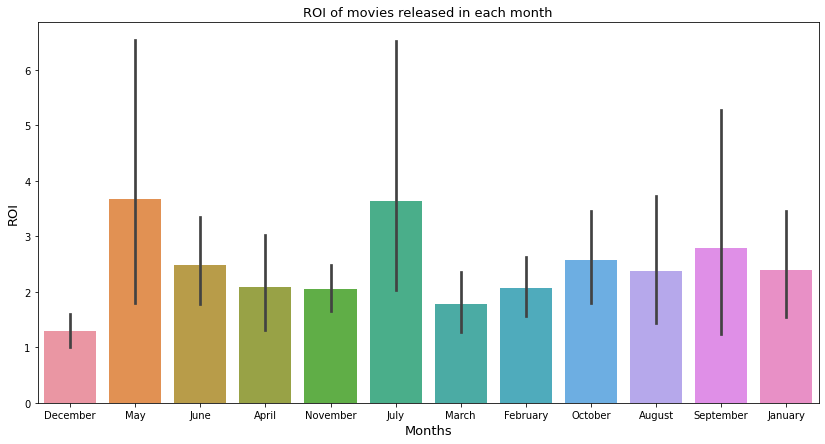

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

fig,ax = plt.subplots(figsize=(14,7))
sns.barplot(data = tn_df, x='months', y='ROI')
ax.set_ylabel('ROI', fontsize=13)
ax.set_xlabel('Months', fontsize=13)
ax.set_title('ROI of movies released in each month', fontsize=13)

##### Need to sort the months in order for the x-axis 

In [53]:
#Create a dictionary 
months_dict = { 'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}

#Map the dictionary to the 'month' column 
tn_df['months_numeric'] = tn_df['months'].apply(lambda x: months_dict.get(x))

#Sort the numeric months column in the ascending order
tn_df = tn_df.sort_values('months_numeric')

C:\Users\hmorareddy\AppData\Local\Temp\ipykernel_20228\368310665.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tn_df['months_numeric'] = tn_df['months'].apply(lambda x: months_dict.get(x))


In [54]:
tn_df

,release_date,movie,production_budget,domestic_gross,worldwide_gross,days,months,year,ROI,months_numeric
id,,,,,,,,,,
87,2008-01-11,The Pirates Who Don't Do Anything: A VeggieTal...,15000000,12981269,13248444,Friday,January,2008,-0.116770,1
92,2015-01-27,Born of War,5000000,0,0,Tuesday,January,2015,-1.000000,1
88,2007-01-30,Farce of the Penguins,5000000,0,0,Tuesday,January,2007,-1.000000,1
91,2017-01-06,Underworld: Blood Wars,35000000,30353973,81209222,Friday,January,2017,1.320263,1
94,2008-01-25,Untraceable,35000000,28687835,52649951,Friday,January,2008,0.504284,1
...,...,...,...,...,...,...,...,...,...,...
68,2006-12-31,Les BronzÃ©s 3: amis pour la vie,42000000,0,83833602,Sunday,December,2006,0.996038,12
65,2010-12-03,The Warrior's Way,42000000,5666340,8514325,Friday,December,2010,-0.797278,12
58,2018-12-25,Holmes & Watson,42000000,30568743,41926605,Tuesday,December,2018,-0.001747,12


In [55]:
tn_df['profit'] = (tn_df['worldwide_gross'] - tn_df['production_budget'])
tn_df.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross,days,months,year,ROI,months_numeric,profit
id,,,,,,,,,,,
87,2008-01-11,The Pirates Who Don't Do Anything: A VeggieTal...,15000000,12981269,13248444,Friday,January,2008,-0.116770,1,-1751556
92,2015-01-27,Born of War,5000000,0,0,Tuesday,January,2015,-1.000000,1,-5000000
88,2007-01-30,Farce of the Penguins,5000000,0,0,Tuesday,January,2007,-1.000000,1,-5000000
91,2017-01-06,Underworld: Blood Wars,35000000,30353973,81209222,Friday,January,2017,1.320263,1,46209222
94,2008-01-25,Untraceable,35000000,28687835,52649951,Friday,January,2008,0.504284,1,17649951


In [56]:
tn_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4387 entries, 87 to 1
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   release_date       4387 non-null   datetime64[ns]
 1   movie              4387 non-null   object        
 2   production_budget  4387 non-null   int64         
 3   domestic_gross     4387 non-null   int64         
 4   worldwide_gross    4387 non-null   int64         
 5   days               4387 non-null   object        
 6   months             4387 non-null   object        
 7   year               4387 non-null   int64         
 8   ROI                4387 non-null   float64       
 9   months_numeric     4387 non-null   int64         
 10  profit             4387 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(6), object(3)
memory usage: 411.3+ KB


Text(0.5, 1.0, 'Monthly profit of movies (2000-2020) ')

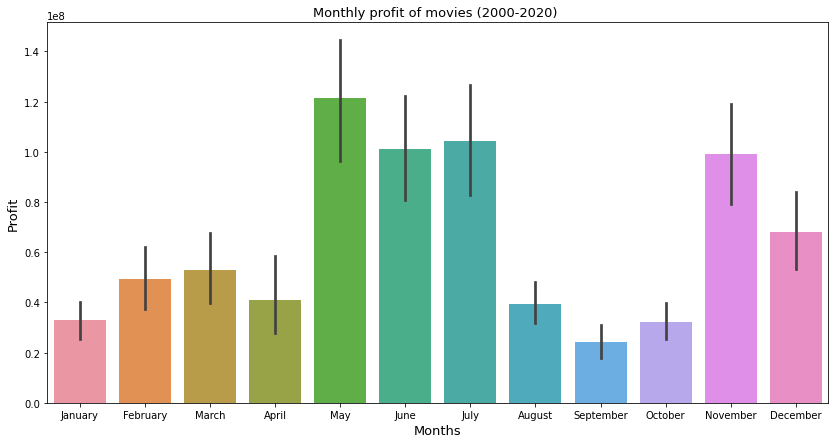

In [57]:
fig,ax = plt.subplots(figsize=(14,7))
sns.barplot(data = tn_df, x='months', y='profit')
ax.set_ylabel('Profit', fontsize=13)
ax.set_xlabel('Months', fontsize=13)
ax.set_title('Monthly profit of movies (2000-2020) ', fontsize=13)

Text(0.5, 1.0, 'Monthly Worldwide Gross earnings of movies (2000-2020) ')

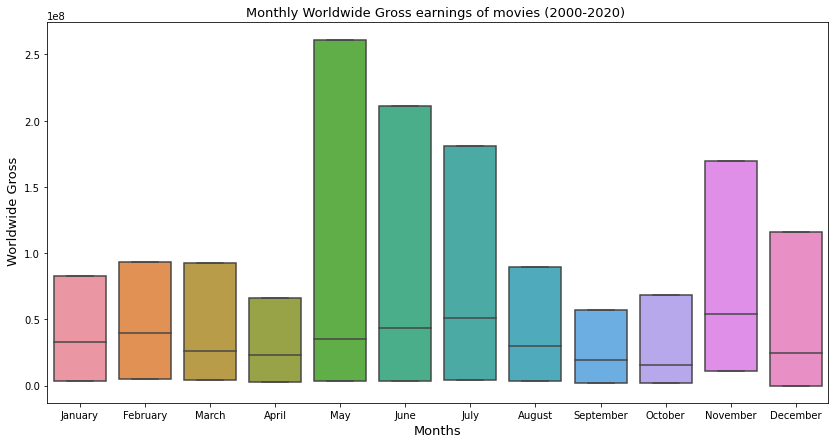

In [58]:
fig,ax = plt.subplots(figsize=(14,7))
sns.boxplot(data = tn_df, x='months', y='worldwide_gross',showfliers=0, whis=0 )
ax.set_ylabel(' Worldwide Gross', fontsize=13)
ax.set_xlabel('Months', fontsize=13)
ax.set_title('Monthly Worldwide Gross earnings of movies (2000-2020) ', fontsize=13)

In [59]:
#Create function for season

def season(s):
    return s.map(lambda x: "Winter" if x > 11 or x<3
                 else ("Spring" if x>=3 and x<6
                       else("Summer" if x>5 and x<9
                            else("Fall"))))

tn_df["season"] = season(tn_df["months_numeric"])

In [60]:
tn_df["season"].value_counts()

Fall      1187
Winter    1133
Spring    1045
Summer    1022
Name: season, dtype: int64

Text(0.5, 1.0, 'Seasonal Worldwide Gross earnings of movies (2000-2020) ')

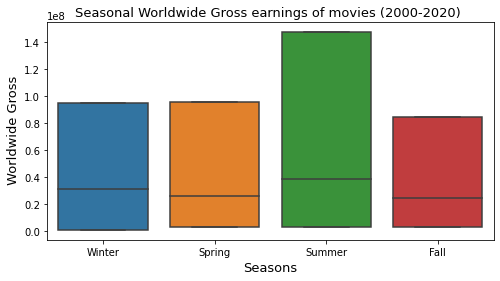

In [61]:
fig,ax = plt.subplots(figsize=(8,4))
sns.boxplot(data = tn_df, x='season', y='worldwide_gross',showfliers=0, whis=0 )
ax.set_ylabel(' Worldwide Gross', fontsize=13)
ax.set_xlabel('Seasons', fontsize=13)
ax.set_title('Seasonal Worldwide Gross earnings of movies (2000-2020) ', fontsize=13)

In [62]:
#Analysis of Gross earnings of movies and season over the last 2 decades
season_gross = (tn_df.groupby(["year","season"])['worldwide_gross'].mean()).sort_values(ascending = False)
season_gross.head()

year  season
2018  Summer    2.126597e+08
2017  Spring    2.032295e+08
      Summer    2.009847e+08
2018  Spring    1.951302e+08
2016  Summer    1.782752e+08
Name: worldwide_gross, dtype: float64

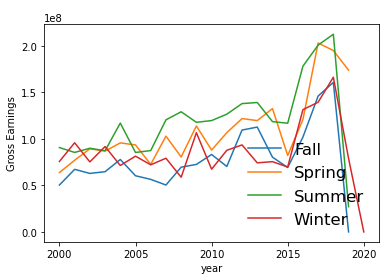

In [63]:
#fig = plt.figure(figsize=(20,7))
fig = season_gross.unstack().plot(kind = "line")
sns.set_context("talk")
plt.title("Release season/Year - Gross Earnings", fontsize = 15, color="white")
plt.ylabel("Gross Earnings")
fig.legend(loc="lower right", frameon=False)

In [64]:
season_profit = (tn_df.groupby(["year","season"])['profit'].mean()).sort_values(ascending = False)


In [65]:
#plt.figure(figsize=(15,8))
#ax = sns.stripplot(x=tn_df.year , y=tn_df.profit, data=tn_df)
#ax.set_title("Profit vs Release Year", fontsize=17)
#ax.set_ylabel('Profit', fontsize=13)
#ax.set_xlabel('Release year', fontsize=13)

In [69]:
#Creates a new title column
tn_df["title"]= tn_df["movie"].map(lambda x :''.join(filter(str.isalnum, x)).lower())
tn_df.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross,days,months,year,ROI,months_numeric,profit,season,title
id,,,,,,,,,,,,,
87,2008-01-11,The Pirates Who Don't Do Anything: A VeggieTal...,15000000,12981269,13248444,Friday,January,2008,-0.116770,1,-1751556,Winter,thepirateswhodontdoanythingaveggietalesmovie
92,2015-01-27,Born of War,5000000,0,0,Tuesday,January,2015,-1.000000,1,-5000000,Winter,bornofwar
88,2007-01-30,Farce of the Penguins,5000000,0,0,Tuesday,January,2007,-1.000000,1,-5000000,Winter,farceofthepenguins
91,2017-01-06,Underworld: Blood Wars,35000000,30353973,81209222,Friday,January,2017,1.320263,1,46209222,Winter,underworldbloodwars
94,2008-01-25,Untraceable,35000000,28687835,52649951,Friday,January,2008,0.504284,1,17649951,Winter,untraceable


In [66]:
#Create query 
q = """
SELECT * 
FROM movie_basics
"""
#create a DF from the IMBD sql table
imdb_movie_ratings = pd.read_sql(q, conn)
#remove na's from the original title due to low numbers
imdb_movie_ratings.dropna(subset=['original_title'], inplace = True)
imdb_movie_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146123 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146123 non-null  object 
 1   primary_title    146123 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146123 non-null  int64  
 4   runtime_minutes  114401 non-null  float64
 5   genres           140734 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 7.8+ MB


In [70]:
#create a column for movie names to merge with other DFs   tn_movie_budgets
imdb_movie_ratings['title'] = imdb_movie_ratings['original_title'].map(lambda x :''.join(filter(str.isalnum, x)).lower())

#sets the index on the title field for the merge
tn_df.set_index('title', inplace=True)
imdb_movie_ratings.set_index('title', inplace=True)
imdb_movie_ratings.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
title,,,,,,
sunghursh,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
ashadkaekdin,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
theothersideofthewind,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
sabsebadasukh,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
latelenovelaerrante,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [72]:
#combine imdb and the numbers tables
rating_and_budgets = tn_df.join(imdb_movie_ratings, how = 'inner')
rating_and_budgets.reset_index(inplace=True)
rating_and_budgets = rating_and_budgets.drop_duplicates(subset='title', keep="first")
rating_and_budgets

,title,release_date,movie,production_budget,domestic_gross,worldwide_gross,days,months,year,ROI,months_numeric,profit,season,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,10cloverfieldlane,2016-03-11,10 Cloverfield Lane,5000000,72082999,108286422,Friday,March,2016,20.657284,3,103286422,Spring,tt1179933,10 Cloverfield Lane,10 Cloverfield Lane,2016,103.0,"Drama,Horror,Mystery"
1,10daysinamadhouse,2015-11-11,10 Days in a Madhouse,12000000,14616,14616,Wednesday,November,2015,-0.998782,11,-11985384,Fall,tt3453052,10 Days in a Madhouse,10 Days in a Madhouse,2015,111.0,Drama
2,127hours,2010-11-05,127 Hours,18000000,18335230,60217171,Friday,November,2010,2.345398,11,42217171,Fall,tt1542344,127 Hours,127 Hours,2010,94.0,"Adventure,Biography,Drama"
3,12rounds,2009-03-27,12 Rounds,20000000,12234694,17306648,Friday,March,2009,-0.134668,3,-2693352,Spring,tt3517850,12 Rounds,12 Rounds,2017,NaN,"Action,Drama,Romance"
4,12strong,2018-01-19,12 Strong,35000000,45819713,71118378,Friday,January,2018,1.031954,1,36118378,Winter,tt1413492,12 Strong,12 Strong,2018,130.0,"Action,Drama,History"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3310,zookeeper,2011-07-08,Zookeeper,80000000,80360866,170805525,Friday,July,2011,1.135069,7,90805525,Summer,tt1222817,Zookeeper,Zookeeper,2011,102.0,"Comedy,Family,Romance"
3311,zoolander2,2016-02-12,Zoolander 2,50000000,28848693,55348693,Friday,February,2016,0.106974,2,5348693,Winter,tt1608290,Zoolander 2,Zoolander 2,2016,101.0,Comedy
3312,zoom,2006-08-11,Zoom,35000000,11989328,12506188,Friday,August,2006,-0.642680,8,-22493812,Summer,tt3763866,Zoom,Zoom,2015,96.0,"Animation,Comedy,Drama"
3316,zootopia,2016-03-04,Zootopia,150000000,341268248,1019429616,Friday,March,2016,5.796197,3,869429616,Spring,tt2948356,Zootopia,Zootopia,2016,108.0,"Adventure,Animation,Comedy"


In [79]:
# Explode the genres
# Convert values into string and split them
rating_and_budgets['genres'] = rating_and_budgets['genres'].str.split(",")
# Convert values into list of strings
rating_and_budgets['genres'] = rating_and_budgets['genres'].tolist()
# Explode list into individual values
rating_and_budgets = rating_and_budgets.explode('genres')
rating_and_budgets.head()

,title,release_date,movie,production_budget,domestic_gross,worldwide_gross,days,months,year,ROI,months_numeric,profit,season,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,list_genres
0,10cloverfieldlane,2016-03-11,10 Cloverfield Lane,5000000,72082999,108286422,Friday,March,2016,20.657284,3,103286422,Spring,tt1179933,10 Cloverfield Lane,10 Cloverfield Lane,2016,103.0,Drama,"[Drama, Horror, Mystery]"
0,10cloverfieldlane,2016-03-11,10 Cloverfield Lane,5000000,72082999,108286422,Friday,March,2016,20.657284,3,103286422,Spring,tt1179933,10 Cloverfield Lane,10 Cloverfield Lane,2016,103.0,Horror,"[Drama, Horror, Mystery]"
0,10cloverfieldlane,2016-03-11,10 Cloverfield Lane,5000000,72082999,108286422,Friday,March,2016,20.657284,3,103286422,Spring,tt1179933,10 Cloverfield Lane,10 Cloverfield Lane,2016,103.0,Mystery,"[Drama, Horror, Mystery]"
1,10daysinamadhouse,2015-11-11,10 Days in a Madhouse,12000000,14616,14616,Wednesday,November,2015,-0.998782,11,-11985384,Fall,tt3453052,10 Days in a Madhouse,10 Days in a Madhouse,2015,111.0,Drama,[Drama]
2,127hours,2010-11-05,127 Hours,18000000,18335230,60217171,Friday,November,2010,2.345398,11,42217171,Fall,tt1542344,127 Hours,127 Hours,2010,94.0,Adventure,"[Adventure, Biography, Drama]"


In [90]:
sorted_df = rating_and_budgets.sort_values(by=['months_numeric'])

Text(0, 0.5, 'Average Gross')

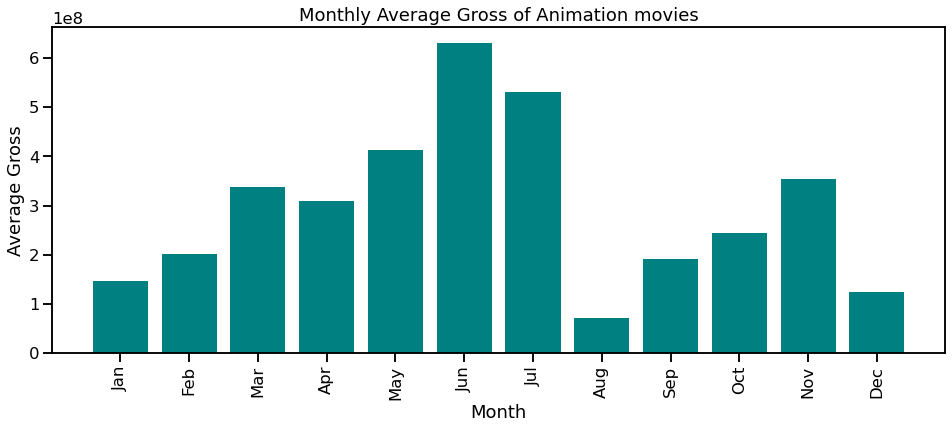

In [98]:
g1_df=sorted_df[sorted_df['genres']=='Animation']
g1_df = g1_df.drop_duplicates('title')
g1a_data = g1_df.groupby(['months_numeric']).worldwide_gross.mean()

# Create a figure and axis
fig, ax = plt.subplots(figsize=(16,6))

# Get x and y data
x1 = g1a_data.index
y1 = g1a_data.values

ax.bar(x1, y1, color='teal')

months =['Jan','Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul','Aug', 'Sep', 'Oct', 'Nov', 'Dec']
months_num = range(1,13)
ax.set_xticks(months_num)
ax.set_xticklabels(months)
plt.xticks(rotation=90)
ax.set_title('Monthly Average Gross of Animation movies')
ax.set_xlabel('Month')
ax.set_ylabel('Average Gross')